# Тестовое задание
Информация о данных: https://ai.stanford.edu/~amaas/data/sentiment/

Короткое объяснение: требуется обучить модель на задачу классификации комментариев пользователей к фильмам, а также сделать возможным интерпретировать ответ в значения от 1 до 10 (например, звезд).

Также, оценки для положительных комментариев находятся в промежутке от 7 до 10, для отрицательных от 1 до 4

In [16]:
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import pickle

from tqdm import tqdm
from catboost import CatBoostClassifier, CatBoostRegressor
from gensim.corpora import Dictionary
from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import tokenize

import sklearn
import torch
import nltk

# Считаем данные

In [3]:
TRAIN_DATA_PATH = 'large-movie-reviews-dataset/acl-imdb-v1/train/'
TEST_DATA_PATH = 'large-movie-reviews-dataset/acl-imdb-v1/test/'

In [4]:
def get_rating(path):
    if path[-5] == '0' and path[-6] == '1':
        return 10
    else:
        return int(path[-5])

def get_target(path):
    if path[-4:-1] == 'pos':
        return 1
    else: 
        return 0

In [5]:
def open_txt(path):
    comments_names = os.listdir(path)
    comments = []
    for comment in tqdm(comments_names):
        with open(os.path.join(path, comment) , encoding="utf8") as f:
            lines = f.readlines()
            target = get_target(path)
            rating = get_rating(comment)
            comments.append([lines[0], target, rating])
    return comments

In [6]:
train_pos = open_txt(TRAIN_DATA_PATH + 'pos/')
train_neg = open_txt(TRAIN_DATA_PATH + 'neg/')
test_pos = open_txt(TEST_DATA_PATH + 'pos/')
test_neg = open_txt(TEST_DATA_PATH + 'neg/')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [01:26<00:00, 144.95it/s]


In [7]:
#словарь
with open('large-movie-reviews-dataset/acl-imdb-v1/imdb.vocab', encoding="utf8") as f:
        all_words = f.readlines()
for i in range(len(all_words)):
    all_words[i] = all_words[i][:-1]
print("Размер словаря, данного в этом датасете: ", len(all_words))

Размер словаря, данного в этом датасете:  89527


In [8]:
train_df = pd.DataFrame(train_pos + train_neg, columns = ['text', 'target', 'rating'])
train_df.head(3)

,text,target,rating
0,Bromwell High is a cartoon comedy. It ran at t...,1,9
1,Homelessness (or Houselessness as George Carli...,1,8
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,10


In [9]:
test_df = pd.DataFrame(test_pos + test_neg, columns = ['text', 'target', 'rating'])
test_df.head(3)

,text,target,rating
0,I went and saw this movie last night after bei...,1,10
1,Actor turned director Bill Paxton follows up h...,1,7
2,As a recreational golfer with some knowledge o...,1,9


# Токенизируем данные

In [10]:
punct_symbols = '"!@#$%^&*():;-+?_=,<>/'
def tokenizer_text(sent):
    tokens = [word.lower() for word in nltk.word_tokenize(sent)]
    tokens = [word for word in tokens if word not in punct_symbols]
    return tokens

In [11]:
train_df['tokenized'] = train_df['text'].apply(tokenizer_text)
test_df['tokenized'] = test_df['text'].apply(tokenizer_text)

In [12]:
train_df.sample(5)

,text,target,rating,tokenized
9340,"This film is an entertaining, fun and quality ...",1,7,"[this, film, is, an, entertaining, fun, and, q..."
17266,It's impossible for me to objectively consider...,0,2,"[it, 's, impossible, for, me, to, objectively,..."
10597,"Pleasant, diverting and charming. The best par...",1,8,"[pleasant, diverting, and, charming, ., the, b..."
17935,Unfortunately the movie is more concerned with...,0,1,"[unfortunately, the, movie, is, more, concerne..."
10893,"* Firstly, although many say it is the worst o...",1,9,"[firstly, although, many, say, it, is, the, wo..."


# Обертка на Word2Vec

In [15]:
class Word2VecWrap:
    def __init__(self, tokens, vec_size, window, min_count, epochs):
        self.tokens = tokens
        self.epochs = epochs
        self.vec_size = vec_size
        self.model_wv = Word2Vec(sentences=tokens,
                                 vector_size=vec_size,
                                 window=window,
                                 min_count=min_count)

    def train(self):
        self.model_wv.train(self.tokens, total_examples=len(self.tokens), epochs=self.epochs)

    def save(self, path):
        self.model_wv.save(path)

    def vocab(self):
        return self.model_wv.wv

# Обучаем и проверяем Word2Vec
Получать векторное представление предложения будем с помощью w2v, где эмбеддинги всех слов в предложении просто будем усреднять
Word2Vec обученный на данном корпусе с нуля показал не очень хорошие результаты, поэтому я беру предобученный

In [31]:
model_down = KeyedVectors.load_word2vec_format('models/model.bin',binary=True,limit=100000)
model_down.vector_size

In [ ]:
"""model_wv = Word2VecWrap(train_df['tokenized'], vec_size=64, window=5, min_count=3, epochs=15)
model_wv.train()
len(model_wv.vocab())
model_wv.save('trained_word2vec.model')
model_wv_1 = Word2Vec.load('models/trained_word2vec.model')
model_wv_1.vector_size"""

In [40]:
def sent2vec_train_down(question, model):
    token_question = np.array(question)
    question_array = np.zeros(model.vector_size)
    count = 0
    for word in token_question:
        if model.__contains__(str(word)):
            question_array += (np.array(model[str(word)])) 
            count += 1
    if count == 0:
        return question_array

    return question_array / count

In [35]:
def cos_sim(a, b):
    similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return similarity

In [108]:
#Как мы видим word2vec работает, ембеддинговое пространство он построил 
mom = sent2vec_train_down(['mom'], model_down)
dad = sent2vec_train_down(['dad'], model_down)
fire = sent2vec_train_down(['fire'], model_down)
print("Косинусное расстояние между словами мама и папа: ", cos_sim(mom, dad), '\n',
     "Косинусное расстояние между словами мама и огонь: ", cos_sim(mom, fire), sep='')

pos_1 = sent2vec_train_down(train_df['tokenized'][100], model_down)
pos_2 = sent2vec_train_down(train_df['tokenized'][200], model_down)
print("Косинусное расстояние между pos предложениями: ", cos_sim(pos_1, pos_2))

Косинусное расстояние между словами мама и папа: 0.6957668000931883
Косинусное расстояние между словами мама и огонь: -0.006360127350753729
Косинусное расстояние между pos предложениями:  0.8746018308738136


# Сравниваем катбуст и регрессию
Будем подавать эмбеддинги предложений в катбуст для предсказания таргета

Попробуем два разных подкхода к задаче: регрессия(предскажем оценку), классификация(предскажем класс, а оценку будет выставлять по вероятностным выходам модели)

## Classification

In [36]:
class CatBoostClassifierWrap:
    def __init__(self, n_estimators, max_depth, learning_rate, verbose=100):
        self.model = CatBoostClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   random_state=42,
                                   verbose=200)

    def fit(self, x_train, y_train):
        self.model.fit(x_train, y_train)

    def save(self, path):
        pickle.dump(self.model, open(path, "wb"))

    def predict(self, x):
        return self.model.predict(x)

    def predict_proba(self, x):
        return self.model.predict_proba(x)

In [47]:
def data_to_model(df, target):
    X, Y = [], []
    for sentence in range(len(df[target])):
        X.append(sent2vec_train_down(df['tokenized'][sentence], model_down))
        Y.append(df[target][sentence])
    return np.array(X), np.array(Y)

In [49]:
X_train_clf, Y_train_clf = data_to_model(train_df, 'target')
X_test_clf, Y_test_clf = data_to_model(test_df, 'target')

In [50]:
model_cl = CatBoostClassifierWrap(n_estimators=1000, max_depth=6, learning_rate=0.1)
model_cl.fit(X_train_clf, Y_train_clf)

0:	learn: 0.6728318	total: 156ms	remaining: 2m 36s
200:	learn: 0.3444917	total: 12s	remaining: 47.7s
400:	learn: 0.2507625	total: 23.6s	remaining: 35.3s
600:	learn: 0.1877634	total: 35s	remaining: 23.2s
800:	learn: 0.1421467	total: 46.4s	remaining: 11.5s
999:	learn: 0.1077014	total: 58.8s	remaining: 0us


In [99]:
clf = sklearn.linear_model.LogisticRegression().fit(X_train_clf, Y_train_clf)

### Оценка результатов
Посмотрим на accuracy, recall, precision на трейне и на тесте

#### Regression

In [100]:
train_predicts = clf.predict(X_train_clf)
print('Accuracy: ', round((train_predicts == Y_train_clf).sum() / len(Y_train_clf), 4), '\n',
      'Precision: ', round(sklearn.metrics.precision_score(Y_train_clf, train_predicts), 4), '\n',
      'Recall: ', round(sklearn.metrics.recall_score(Y_train_clf, train_predicts), 4), sep='')

Accuracy: 0.8324
Precision: 0.8303
Recall: 0.8355


In [101]:
test_predicts = clf.predict(X_test_clf)
print('Accuracy: ', round((test_predicts == Y_test_clf).sum() / len(Y_test_clf), 4), '\n',
      'Precision: ', round(sklearn.metrics.precision_score(Y_test_clf, test_predicts), 4), '\n',
      'Recall: ', round(sklearn.metrics.recall_score(Y_test_clf, test_predicts), 4), sep='')

Accuracy: 0.8253
Precision: 0.8264
Recall: 0.8235


#### CatBoost

In [102]:
train_predicts = model_cl.predict(X_train_clf)
print('Accuracy: ', round((train_predicts == Y_train_clf).sum() / len(Y_train_clf), 4), '\n',
      'Precision: ', round(sklearn.metrics.precision_score(Y_train_clf, train_predicts), 4), '\n',
      'Recall: ', round(sklearn.metrics.recall_score(Y_train_clf, train_predicts), 4), sep='')

Accuracy: 0.9942
Precision: 0.9953
Recall: 0.9931


In [103]:
test_predicts = model_cl.predict(X_test_clf)
print('Accuracy: ', round((test_predicts == Y_test_clf).sum() / len(Y_test_clf), 4), '\n',
      'Precision: ', round(sklearn.metrics.precision_score(Y_test_clf, test_predicts), 4), '\n',
      'Recall: ', round(sklearn.metrics.recall_score(Y_test_clf, test_predicts), 4), sep='')

Accuracy: 0.8156
Precision: 0.815
Recall: 0.8167


## Regressor

In [104]:
class CatBoostRegressorWrap:
    def __init__(self, n_estimators, max_depth, learning_rate, loss_function, verbose=100):
        self.model = CatBoostRegressor(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   random_state=42,
                                   loss_function=loss_function,
                                   verbose=200)

    def fit(self, x_train, y_train):
        self.model.fit(x_train, y_train)

    def save(self, path):
        pickle.dump(self.model, open(path, "wb"))

    def predict(self, x):
        return self.model.predict(x)

In [105]:
X_train_reg, Y_train_reg = data_to_model(train_df, 'rating')
X_test_reg, Y_test_reg = data_to_model(test_df, 'rating')

In [106]:
model_reg = CatBoostRegressorWrap(n_estimators=1000, max_depth=6, learning_rate=0.1, loss_function='MAE')
model_reg.fit(X_train_reg, Y_train_reg)

0:	learn: 3.1710949	total: 99.1ms	remaining: 1m 38s
200:	learn: 1.8234002	total: 10.7s	remaining: 42.4s
400:	learn: 1.6477047	total: 21s	remaining: 31.4s
600:	learn: 1.5438236	total: 31.4s	remaining: 20.9s
800:	learn: 1.4733364	total: 41.7s	remaining: 10.4s
999:	learn: 1.4197199	total: 52.7s	remaining: 0us


In [109]:
reg = sklearn.linear_model.Ridge(alpha=1).fit(X_train_reg, Y_train_reg)

In [136]:
pkl_filename = "model_regression.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(reg, file)
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

### Посмотрим на MAE и распределение таргетов

In [135]:
(abs(Y_train_reg - reg.predict(X_train_reg))).mean()

2.018895864042252

In [134]:
(abs(Y_test_reg - reg.predict(X_test_reg))).mean()

2.0789470602026516

In [124]:
(abs(Y_train_reg - model_reg_1.predict(X_train_reg))).mean()

3.7279131908828975

In [126]:
(abs(Y_test_reg - model_reg_1.predict(X_test_reg))).mean()

3.759994174584564

#### Как видим, катбуст справляется намного хуже, что в задаче регрессии, что в задаче классификации. Это связано с тем, что на предобученных векторах word2vec имеет размерность 300. Выберем regression задачу и, собственно, линейную регрессию

In [111]:
sns.set(rc={'figure.figsize':(5, 3)})

Распределение на train

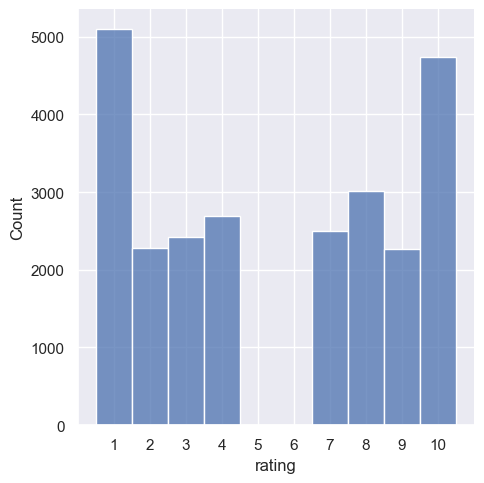

In [112]:
p = sns.displot(train_df, x ='rating', discrete=True)
p.set(xticks=np.arange(1,11))

Распределение на test

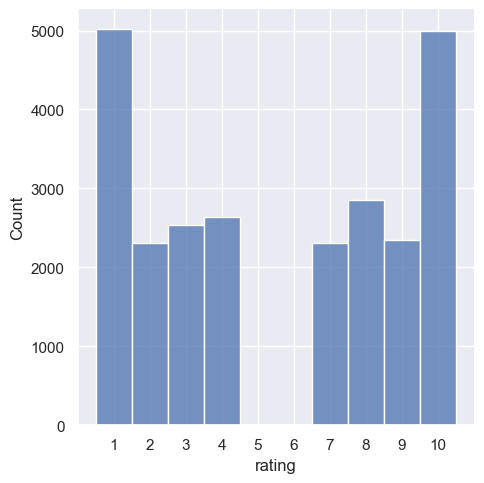

In [113]:
p = sns.displot(test_df, x ='rating', discrete=True)
p.set(xticks=np.arange(1,11))

Распределение предсказаний

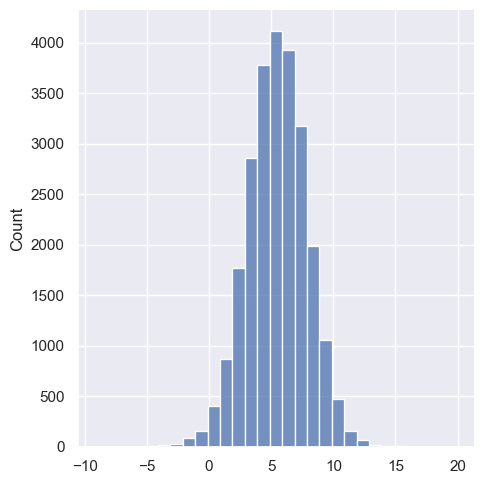

In [120]:
p = sns.displot(reg.predict(X_test_reg), discrete=True)
#p.set(xticks=np.arange(-1,12))

Распределение предсказаний не очень похоже на реальное распределение. Видно, что предсказания кучкуются в интервале 4-6, а также есть выбросы за 1 и 10, их будем считать как оценку 1 и 10 соответственно. Попробуем сделать небольшие преобразования над нашими данными, чтобы оценка комментария была менее "нейтральной"

In [116]:
def remake(x):
    flag = -1 if x < 5 else 1
    treshold = 5 if x < 5 else 11
    x += flag * (treshold - x) * 0.5
    if x < 1:
        return 1
    if x > 10:
        return 10
    return x

remaker = np.vectorize(remake)

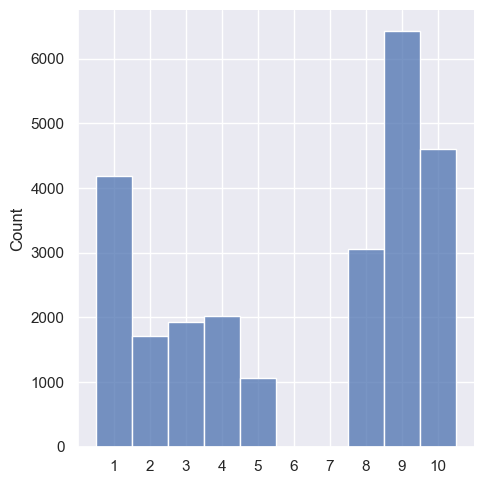

In [117]:
a = remaker(model_reg.predict(X_test_reg))
p = sns.displot(a, discrete=True)
p.set(xticks=np.arange(1,11))

In [118]:
abs((Y_test_reg - a).mean())

0.6940802483071414

Так распределение выглядит более похожим на тестовое, а погрешность таких выводов 0.6, теперь модель намного точнее может классифицировать классы на положительные и отрицательные, просто выставим порог в виде 6 баллов!

Такие эвристические преобразования помогли нам примерно соотнести распределения выходов модели и таргетов. Т.к. оценка по шкале от 1 до 10 самого комментария - дело очень субъективное (даже человек не может оценить чужой комментарий по 10-ти бальной шкале точно, скорее он назовет интервал с погрешностью в +-1 балл, например: 7-9, кстати, регрессионная модель предсказывает примерно с такой же погрешностью), то опираться скорее будем на positive/negative оценку, а 10-бальная шкала будет уже второстепенной задачей

# Выводы, идеи, предложения
### Это ноутбук показывает ML/DL часть, в train.py/model.py будет меньше кода, т.к. тут присутствует  анализ и лишние блоки кода для проверки работоспособности кода и демонстрации результатов. По итогу, опираться будем на регрессионную модель, т.к. она показала более стабильный результат.
### Без этих эвристических преобразований понятно, что модель переобучилась, с этим можно бороться разными способами, один из самых главных - тюнинг параметров, причем не только самого бустинга, но и w2v, размерности векторов(ее можно сжать с помощью SVD-разложения) и прочих параметров.
### Также было неколько идей: взять трансформер с HF, взять tf-idf или doc2vec(т.к. комментарии достаточно длинные), можно было попробовать RNN и предсказывать таргет сразу одной моделью, а не как в моем решении (сначала получаем ембеддинговое представление word2vec-а, а потом передаем в catboost).
### Вариантов очень много, но все пробовать в данном случае смысла не имеет, это тестовое задание и одно решение из множества возможных :)